# CNV Diversity
## How many CNV events occur in the chemostat?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

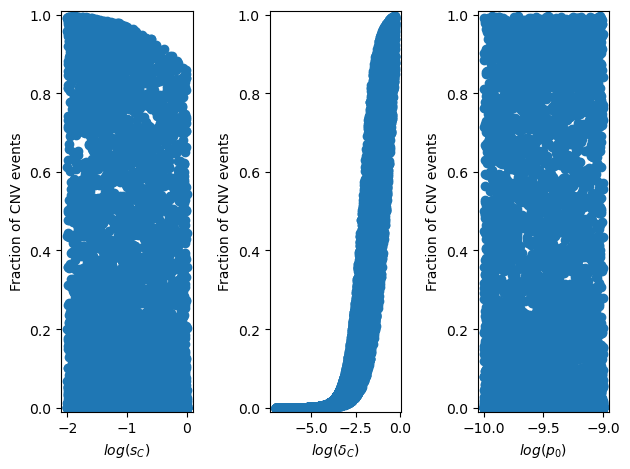

In [22]:
# Pre-simulated data - 10k simulations
# Each simulation's output is the comulative number of CNV events
div_df = pd.read_csv('presimulated_data/WF_presimulated_data_10000_diversity.csv', header=None)
div_df.columns = ['CNVs']

# Simulated parameters
div_theta = pd.read_csv('presimulated_data/WF_presimulated_theta_10000_diversity.csv', header=None)
div_theta.columns = ['$log(s_C)$', '$log(δ_C)$', '$log(p_0)$']

# Plotting CNV events as a function of model parameters
fig, ax = plt.subplots(1,3, tight_layout=True)
N = float(3.3e8)
for i in range(len(div_theta.columns)):
    c = div_theta.columns[i]
    ax[i].scatter(div_theta[c],div_df['CNVs'].astype(float) / N)
    ax[i].set_xlabel(c)
    ax[i].set_ylabel('Fraction of CNV events')
    ax[i].set_ylim(-0.01,1.01)

# ax[1].scatter(x=div_theta['$log(δ_C)$'], y= 2*3**div_theta['$log(δ_C)$'],color='k')

# CNV Events by $\delta_C$
## Assuming no selection, the total number of CNV events is a geometric sum:
### $N_{cnv} = \delta_C + \delta_C*(1-\delta_C-\delta_B) + \delta_C*{(1-\delta_C-\delta_B)^2}+...=$
### $ = { {\delta_C*{[1-(1-\delta_C-\delta_B)^{G}]}} \over {\delta_C+\delta_B} }$

Text(0, 0.5, 'Total CNV events')

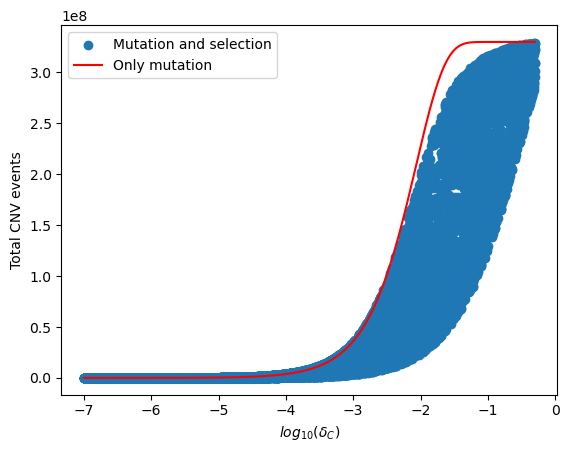

In [25]:
plt.scatter(div_theta['$log(δ_C)$'],div_df['CNVs'].astype(float), label='Mutation and selection')

x = 10**div_theta['$log(δ_C)$'].sort_values()
y = x*((1-x-(10**-5))**116-1)/(-x-(10**-5))
plt.plot(np.log10(x),y*N, color='red', label = 'Only mutation')
plt.legend()
# plt.ylim(0,5e6)
plt.xlabel('$log_{10}(δ_C)$')
plt.ylabel('Total CNV events')
# plt.xlim(-6,-3)

# CNV events distribution estimation

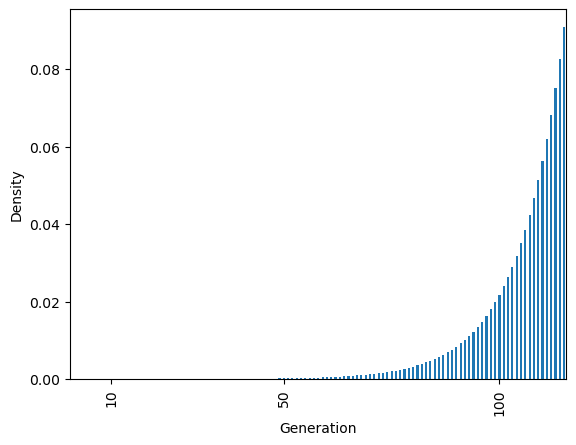

In [6]:
def plot_cnvs_dist(s, g):
    f = 1+s # fitness
    N = np.array([f**i for i in range(1,g)])
    N/=N.sum()
    S = pd.Series(index=np.arange(1,g),data=N)
    S.plot(kind='bar')
    plt.xticks([9,49,99])
    plt.xlabel('Generation')
    plt.ylabel('Density')
    return

plot_cnvs_dist(s=0.1,g=116)